参数配置,用于后续创建模型

In [1]:
from transformers import PretrainedConfig
import torch.nn as nn
import torch
from transformers.models.llama4.modeling_llama4 import reshape_for_broadcast
from typing import Tuple
import torch.nn.functional as F
import math


class ModelConfig(PretrainedConfig):
    model_type = "Tiny-K"

    def __init__(
            self,
            dim: int = 768,  # 模型维度
            n_layers: int = 12,  # Transformer的层数
            n_heads: int = 16,  # 注意力机制的头数
            n_kv_heads: int = 8,  # 键值头的数量
            vocab_size: int = 6144,  # 词汇表大小
            hidden_dim: int = None,  # 隐藏层维度
            multiple_of: int = 64,
            norm_eps: float = 1e-5,  # 归一化层的eps
            max_seq_len: int = 512,  # 最大序列长度
            dropout: float = 0.0,  # dropout概率
            flash_attn: bool = True,  # 是否使用Flash Attention
            **kwargs,
    ):
        self.dim = dim
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.n_kv_heads = n_kv_heads
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        self.multiple_of = multiple_of
        self.norm_eps = norm_eps
        self.max_seq_len = max_seq_len
        self.dropout = dropout
        self.flash_attn = flash_attn
        super().__init__(**kwargs)

C:\Users\admin\python\conda\envs\lightning_learn\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


RMSNorm

In [2]:
class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.g = nn.Parameter(torch.ones(dim))

    def _norm(self, x):
        # 计算RMSNorm的核心部分
        # x.pow(2).mean(-1, keepdim=True)计算了输入x的平方的均值
        # torch.rsqrt是平方根的倒数，这样就得到了RMSNorm的分母部分，再加上eps防止分母为0
        # 最后乘以x，得到RMSNorm的结果
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        # forward函数是模型的前向传播
        # 首先将输入x转为float类型，然后进行RMSNorm，最后再转回原来的数据类型
        # 最后乘以weight，这是RMSNorm的一个可学习的缩放因子
        # 当模型使用混合精度（如 torch.float16/torch.bfloat16）训练时，
        # 直接用低精度计算平方均值可能导致数值下溢（小数值的平方会变成 0），
        # 进而引发归一化后的梯度爆炸 / NaN；
        x = self._norm(x.float()).type_as(x)
        return self.g * x


args = ModelConfig()
norm = RMSNorm(args.dim, eps=args.norm_eps)
x = torch.randn(2, 3, args.dim)
print(x.shape, norm(x).shape)

torch.Size([2, 3, 768]) torch.Size([2, 3, 768])


## 构建LLaMA2 Attention
使用GQA (Grouped-Query Attention)
<img src="./LLaMA2_Attention.png" width="320" height="240">


GQA将多个Q成组,因此需要重复KV n次

In [3]:
def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    bs, slen, n_kv_heads, head_dim = x.shape
    if n_rep == 1:
        return x

    # 逻辑：(B, S, H, D) -> (B, S, H, 1, D) -> (B, S, H, R, D) -> (B, S, H*R, D)
    return (
        # 使用None索引使得维度匹配,从而执行expand操作
        x[:, :, :, None, :]
        .expand(bs, slen, n_kv_heads, n_rep, head_dim)
        .reshape(bs, slen, n_kv_heads * n_rep, head_dim)
    )

## 旋转位置编码(Rotary Positional Embedding, RoPE)
![image.png](./RoPE.png)
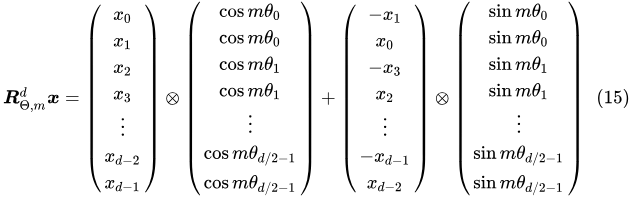

In [4]:
def precompute_freqs_cis(dim: int, end: int, theta: float = 10000.0):
    # torch.arange(0, dim, 2)[: (dim // 2)].float()生成了一个从0开始，步长为2的序列，长度为dim的一半
    # 然后每个元素除以dim，再取theta的倒数，得到频率
    # -2(i-1)/d
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2) / dim))
    t = torch.arange(end, device=freqs.device)
    # 计算外积，得到一个二维矩阵，每一行是t的元素乘以freqs的元素
    freqs = torch.outer(t, freqs)
    # 计算频率的余弦值，得到实部
    freqs_cos = torch.cos(freqs)
    # 计算频率的正弦值，得到虚部
    freqs_sin = torch.sin(freqs)
    return freqs_cos, freqs_sin

In [5]:
def apply_rotary_emb(
        xq: torch.Tensor,
        xk: torch.Tensor,
        freqs_cos: torch.Tensor,
        freqs_sin: torch.Tensor,
) -> Tuple[torch.Tensor, torch.Tensor]:
    # 将查询和键张量转换为浮点数，并重塑形状以分离实部和虚部
    xq_r, xq_i = xq.float().reshape(xq.shape[:-1] + (-1, 2)).unbind(-1)
    xk_r, xk_i = xk.float().reshape(xk.shape[:-1] + (-1, 2)).unbind(-1)

    freqs_cos, freqs_sin = reshape_for_broadcast(freqs_cos, xq_r), reshape_for_broadcast(freqs_sin, xq_r)
    # 应用旋转，分别计算旋转后的实部和虚部
    xq_out_r = xq_r * freqs_cos - xq_i * freqs_sin
    xq_out_i = xq_r * freqs_sin + xq_i * freqs_cos
    xk_out_r = xk_r * freqs_cos - xk_i * freqs_sin
    xk_out_i = xk_r * freqs_sin + xk_i * freqs_cos
    # 将最后两个维度合并，并还原为原始张量的形状
    xq_out = torch.stack([xq_out_r, xq_out_i], dim=-1).flatten(3)
    xk_out = torch.stack([xk_out_r, xk_out_i], dim=-1).flatten(3)

    return xq_out.type_as(xq), xk_out.type_as(xk)

In [6]:
xq = torch.randn(1, 50, 6, 48)  # bs, seq_len, dim//n_head, n_head_dim
xk = torch.randn(1, 50, 6, 48)  # bs, seq_len, dim//n_head, n_head_dim

# 使用 precompute_freqs_cis 函数获取 sin和cos
cos, sin = precompute_freqs_cis(288 // 6, 50)
print(cos.shape, sin.shape)
xq_out, xk_out = apply_rotary_emb(xq, xk, cos, sin)

xq_out.shape, xk_out.shape


torch.Size([50, 24]) torch.Size([50, 24])


(torch.Size([1, 50, 6, 48]), torch.Size([1, 50, 6, 48]))

## Attention

In [7]:
class Attention(nn.Module):
    def __init__(self, args: ModelConfig):
        super().__init__()
        # 是否使用kv head
        self.n_kv_heads = args.n_kv_heads if args.n_kv_heads is not None else args.n_heads
        # 模型并行处理大小，默认为1。
        model_parallel_size = 1
        # 本地计算头数，等于总头数除以模型并行处理大小。
        self.n_local_heads = args.n_heads // model_parallel_size
        self.n_local_kv_heads = self.n_kv_heads // model_parallel_size

        # 本地计算头数，等于总头数除以模型并行处理大小。
        self.n_rep = self.n_local_heads // self.n_local_kv_heads

        # 每个头的维度，等于模型维度除以头的总数
        self.head_dim = args.dim // args.n_heads

        self.wq = nn.Linear(args.dim, args.n_heads * self.head_dim, bias=False)
        self.wk = nn.Linear(args.dim, self.n_kv_heads * self.head_dim, bias=False)
        self.wv = nn.Linear(args.dim, self.n_kv_heads * self.head_dim, bias=False)

        self.wo = nn.Linear(args.n_heads * self.head_dim, args.dim, bias=False)

        self.attn_dropout = nn.Dropout(args.dropout)
        self.resid_dropout = nn.Dropout(args.dropout)
        self.dropout = args.dropout

        # 检查是否使用Flash Attention（需要PyTorch >= 2.0）。
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.flash:
            # 若不支持Flash Attention，则使用手动实现的注意力机制，并设置mask。
            print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
            # 创建一个上三角矩阵，用于遮蔽未来信息。
            mask = torch.full((1, 1, args.max_seq_len, args.max_seq_len), float("-inf"))
            mask = torch.triu(mask, diagonal=1)
            # 注册为模型的缓冲区
            self.register_buffer("mask", mask)

    def forward(self, x: torch.Tensor, freqs_cos: torch.Tensor, freqs_sin: torch.Tensor):
        # [batch_size, seq_len, dim]
        bsz, seqlen, _ = x.shape
        xq, xk, xv = self.wq(x), self.wk(x), self.wv(x)
        xq = xq.view(bsz, seqlen, self.n_local_heads, self.head_dim)
        xk = xk.view(bsz, seqlen, self.n_local_kv_heads, self.head_dim)
        xv = xv.view(bsz, seqlen, self.n_local_kv_heads, self.head_dim)
        # RoPE
        xq, xk = apply_rotary_emb(xq, xk, freqs_cos, freqs_sin)

        xk = repeat_kv(xk, self.n_rep)
        xv = repeat_kv(xv, self.n_rep)

        # 将头作为批次维度处理。
        xq = xq.transpose(1, 2)
        xk = xk.transpose(1, 2)
        xv = xv.transpose(1, 2)
        # 根据是否支持Flash Attention，选择实现方式。
        if self.flash:
            # 使用Flash Attention。
            output = torch.nn.functional.scaled_dot_product_attention(xq, xk, xv, attn_mask=None,
                                                                      dropout_p=self.dropout if self.training else 0.0,
                                                                      is_causal=True)
        else:
            # 使用手动实现的注意力机制。
            scores = torch.matmul(xq, xk.transpose(2, 3)) / math.sqrt(self.head_dim)
            assert hasattr(self, 'mask')
            scores = scores + self.mask[:, :, :seqlen, :seqlen]
            scores = F.softmax(scores.float(), dim=-1).type_as(xq)
            scores = self.attn_dropout(scores)
            output = torch.matmul(scores, xv)

        # 恢复时间维度并合并头。
        output = output.transpose(1, 2).contiguous().view(bsz, seqlen, -1)

        # 最终投影回残差流。
        output = self.wo(output)
        output = self.resid_dropout(output)
        return output

In [8]:
# 创建Attention实例
attention_model = Attention(args)

# 模拟输入数据
batch_size = 1
seq_len = 50  # 假设实际使用的序列长度为50
dim = args.dim
x = torch.rand(batch_size, seq_len, dim)  # 随机生成输入张量
freqs_cos = torch.rand(seq_len, dim // 2)  # 模拟cos频率，用于RoPE
freqs_sin = torch.rand(seq_len, dim // 2)  # 模拟sin频率，用于RoPE

freqs_cos, freqs_sin = precompute_freqs_cis(dim // args.n_heads, seq_len)

# 运行Attention模型
output = attention_model(x, freqs_cos, freqs_sin)

# attention出来之后的形状 依然是[batch_size, seq_len, dim]
print("Output shape:", output.shape)


Output shape: torch.Size([1, 50, 768])


LLaMA2的MLP

In [9]:
class MLP(nn.Module):
    def __init__(self, dim: int, hidden_dim: int, multiple_of: int, dropout: float):
        super().__init__()
        # 如果没有指定隐藏层的维度，我们将其设置为输入维度的4倍
        # 然后将其减少到2/3，最后确保它是multiple_of的倍数
        if hidden_dim is None:
            hidden_dim = 4 * dim
            hidden_dim = int(2 * hidden_dim / 3)
            hidden_dim = multiple_of * ((hidden_dim + multiple_of - 1) // multiple_of)
        # 定义第一层线性变换，从输入维度到隐藏维度
        self.w1 = nn.Linear(dim, hidden_dim, bias=False)
        # 定义第二层线性变换，从隐藏维度到输入维度
        self.w2 = nn.Linear(hidden_dim, dim, bias=False)
        # 定义第三层线性变换，从输入维度到隐藏维度
        self.w3 = nn.Linear(dim, hidden_dim, bias=False)
        # 定义dropout层，用于防止过拟合
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # 前向传播函数
        # 首先，输入x通过第一层线性变换和SILU激活函数
        # 然后，结果乘以输入x通过第三层线性变换的结果
        # 最后，通过第二层线性变换和dropout层
        return self.dropout(self.w2(F.silu(self.w1(x)) * self.w3(x)))


In [10]:
# 创建MLP实例
mlp = MLP(args.dim, args.hidden_dim, args.multiple_of, args.dropout)
# 随机生成数据
x = torch.randn(1, 50, args.dim)
# 运行MLP模型
output = mlp(x)
# 输出和输入形状一致
print(x.shape, output.shape)


torch.Size([1, 50, 768]) torch.Size([1, 50, 768])


Decoder

In [11]:
class DecoderLayer(nn.Module):
    def __init__(self, layer_id, args: ModelConfig, ):
        super().__init__()

        self.dim = args.dim
        self.attn = Attention(args)
        self.n_heads = args.n_heads
        self.head_dim = args.dim // args.n_heads
        self.feed_forward = MLP(args.dim, args.hidden_dim, args.multiple_of, args.dropout)
        self.layer_id = layer_id
        # 注意力计算的归一化层
        self.attention_norm = RMSNorm(args.dim, eps=args.norm_eps)
        # feed forward的归一化层
        self.ff_norm = RMSNorm(args.dim, eps=args.norm_eps)

    def forward(self, x: torch.Tensor, freqs_cos: torch.Tensor, freqs_sin: torch.Tensor):
        h = x + self.attn(self.attention_norm(x), freqs_cos, freqs_sin)
        out = h + self.feed_forward(self.ff_norm(h))
        return out

In [12]:
decoder = DecoderLayer(1, args)
x = torch.randn(1, 50, args.dim)
freqs_cos, freqs_sin = precompute_freqs_cis(args.dim // args.n_heads, 50)
out = decoder(x, freqs_cos, freqs_sin)
print(x.shape, out.shape)

torch.Size([1, 50, 768]) torch.Size([1, 50, 768])


In [13]:
from transformers.modeling_outputs import  CausalLMOutputWithPast
from typing import Optional
from transformers.modeling_utils import PreTrainedModel
class Transformer(PreTrainedModel):
    config_class = ModelConfig  # 配置类
    last_loss: Optional[torch.Tensor] # 记录最后一次计算的损失
    def __init__(self, args: ModelConfig):
        super().__init__(args)
        self.args=args
        self.vocab_size = args.vocab_size
        self.num_layers = args.n_layers
        # embedding
        self.tok_embeddings=nn.Embedding(args.vocab_size, args.dim)
        self.dropout = nn.Dropout(args.dropout)

        # decoder
        self.n_layers = args.n_layers
        self.layers = nn.ModuleList([])
        for i in range(args.n_layers):
            self.layers.append( DecoderLayer(i, args) )
        self.norm = RMSNorm(args.dim, eps=args.norm_eps)
        self.output = nn.Linear(args.dim, args.vocab_size, bias=False)
        # 将词嵌入层的权重与输出层的权重共享,这里是一个经典的技巧，embedding和liner的形状一致，可以共享权重,具体不赘述
        self.tok_embeddings.weight = self.output.weight

        # 相对位置嵌入的频率,和torch.parameter不同,register_buffer的参数是无梯度不被训练的,用于记录常量,且模型保存时也会保存这部分参数
        freqs_cos, freqs_sin = precompute_freqs_cis(self.args.dim // self.args.n_heads, self.args.max_seq_len)
        self.register_buffer("freqs_cos", freqs_cos, persistent=False)
        self.register_buffer("freqs_sin", freqs_sin, persistent=False)

        # 初始化所有权重
        self.apply(self._init_weights)
         # 初始化最后一次前向传播的损失属性

        # 对残差进行特殊的缩放初始化
        for pn, p in self.named_parameters():
            # wo.weight: 通常指 Attention 层的输出投影矩阵
            # w3.weight 前馈神经网络（FFN/MLP）的下投影矩阵
            # 为了防止随着网络层数变深，残差连接带来的信号方差（Variance）无限累积,在GPT2中也有相同的操作
            if pn.endswith('w3.weight') or pn.endswith('wo.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * args.n_layers))

        self.last_loss = None
        # class transformers.modeling_outputs.CausalLMOutputWithPast
        self.OUT = CausalLMOutputWithPast()  # 输出容器
        self._no_split_modules = [name for name, _ in self.named_modules()]  # 不分割的模块列表


    def _init_weights(self, module):
        # 初始化权重
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, x: torch.Tensor, targets: Optional[torch.Tensor] = None,**kwargs)->torch.Tensor :
        """

        :param x: input

        self.OUT: CausalLMOutputWithPast, 包含 logits 和损失
        """
        if 'input_ids' in kwargs:
            x = kwargs['input_ids']
        if 'attention_mask' in kwargs:
            targets = kwargs['attention_mask']
        _bsz,seqlen=x.shape
        h=self.tok_embeddings(x)
        h=self.dropout(h)
        # 前seqlen项
        freqs_cos, freqs_sin = self.freqs_cos[:seqlen], self.freqs_sin[:seqlen]
        for layer in self.layers:
            h = layer(h, freqs_cos, freqs_sin)
        h=self.norm(h)
        if targets is not None:
            # 训练
            # 如果给定了目标，计算损失
            logits = self.output(h)
            self.last_loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=0, reduction='none')
        else:
            # 推理
            # 推理时的小优化：只对最后一个位置的输出进行前向传播
            # logits: [bsz, 1, vocab_size]
            logits = self.output(h[:, [-1], :])
            self.last_loss = None

        # 设置输出
        self.OUT.__setitem__('logits', logits)
        self.OUT.__setitem__('last_loss', self.last_loss)
        return self.OUT

    # 仅用于推理,节省资源(不计算梯度等信息
    @torch.inference_mode()
    def generate(self, idx, stop_id=None, max_new_tokens=256, temperature=1.0, top_k=None):
        """
        给定输入序列 idx（形状为 (bz,seq_len) 的长整型张量），通过多次生成新 token 来完成序列。
        在 model.eval() 模式下运行。效率较低的采样版本，没有使用键k/v cache。
        """
        index = idx.shape[1]
        for _ in range(max_new_tokens):
            # 如果序列上下文过长，截断它到最大长度
            idx_cond = idx if idx.size(1) <= self.args.max_seq_len else idx[:, -self.args.max_seq_len:]

            # 前向传播获取序列中最后一个位置的 logits
            logits = self(idx_cond).logits
            logits = logits[:, -1, :] # 只保留最后一个时间步的输出

            if temperature == 0.0:
                # 选择最有可能的索引
                _, idx_next = torch.topk(logits, k=1, dim=-1)
            else:
                # 缩放 logits 并应用 softmax
                logits = logits / temperature
                if top_k is not None:
                    v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                    logits[logits < v[:, [-1]]] = -float('Inf')
                probs = F.softmax(logits, dim=-1)
                idx_next = torch.multinomial(probs, num_samples=1)


            if idx_next == stop_id:
                break

            # 将采样的索引添加到序列中并继续
            idx = torch.cat((idx, idx_next), dim=1)

        return idx[:, index:] # 只返回生成的token

In [14]:
x=torch.randint(0,6144,(1,50))
model=Transformer(args= args)
# 计算全部参数
num_params=sum(p.numel() for p in model.parameters())
print(f'参数数量:{num_params}')

out=model(x)
print(out.logits.shape)

参数数量:82594560
torch.Size([1, 1, 6144])


## Tokenizer

下面使用 Hugging Face 的 tokenizers 库来训练一个 BPE Tokenizer。

In [15]:
import random
import json
import os
from transformers import AutoTokenizer, PreTrainedTokenizerFast
from tokenizers import (
    decoders,
    models,
    pre_tokenizers,
    trainers,
    Tokenizer,
)
from tokenizers.normalizers import NFKC
from typing import Generator


In [16]:
def read_texts_from_jsonl(file_path: str)-> Generator[str, None, None]:
    """
    从 jsonl 文件中读取文本。
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        for line_num,line in enumerate(f,1):
            try:
                data = json.loads(line)
                if 'text' not in data:
                    raise KeyError(f"Missing 'text' field in line {line_num}")
                text = data['text']
                yield text
            except json.JSONDecodeError:
                print(f"Error decoding JSON in line {line_num}")
                continue
            except KeyError as e:
                print(e)
                continue


In [17]:
def create_tokenizer_config(save_dir:str)->None:
    """创建完整的tokenizer配置文件"""
    config = {
        "add_bos_token": False,
        "add_eos_token": False,
        "add_prefix_space": False,
        "bos_token": "<|im_start|>",
        "eos_token": "<|im_end|>",
        "pad_token": "<|im_end|>",
        "unk_token": "<unk>",
        "model_max_length": 1000000000000000019884624838656,
        "clean_up_tokenization_spaces": False,
        "tokenizer_class": "PreTrainedTokenizerFast",
        "chat_template": (
            "{% for message in messages %}"
            "{% if message['role'] == 'system' %}"
            "<|im_start|>system\n{{ message['content'] }}<|im_end|>\n"
            "{% elif message['role'] == 'user' %}"
            "<|im_start|>user\n{{ message['content'] }}<|im_end|>\n"
            "{% elif message['role'] == 'assistant' %}"
            "<|im_start|>assistant\n{{ message['content'] }}<|im_end|>\n"
            "{% endif %}"
            "{% endfor %}"
            "{% if add_generation_prompt %}"
            "{{ '<|im_start|>assistant\n' }}"
            "{% endif %}"
        )
    }
    with open(os.path.join(save_dir, "tokenizer_config.json"), "w", encoding="utf-8") as f:
        json.dump(config, f, ensure_ascii=False, indent=4)

    # 创建special_tokens_map.json
    special_tokens_map = {
        "bos_token": "<|im_start|>",
        "eos_token": "<|im_end|>",
        "unk_token": "<unk>",
        "pad_token": "<|im_end|>",
        "additional_special_tokens": ["<s>", "</s>"]
    }
    with open(os.path.join(save_dir, "special_tokens_map.json"), "w", encoding="utf-8") as f:
        json.dump(special_tokens_map, f, ensure_ascii=False, indent=4)

In [18]:
def train_tokenizer(data_path: str, save_dir: str, vocab_size: int = 8192) -> None:
    """
    训练一个 tokenizer。
    """
    os.makedirs(save_dir, exist_ok=True)
    tokenizer = Tokenizer(models.BPE(unk_token="<unk>"))
    tokenizer.normalizer = NFKC()
    tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=True)
    tokenizer.decoder=decoders.ByteLevel()

    # 配置特殊token
    special_tokens = [
        "<unk>",
        "<s>",
        "</s>",
        "<|im_start|>",
        "<|im_end|>"
    ]
    trainer=trainers.BpeTrainer(
        vocab_size=vocab_size,
        special_tokens=special_tokens,
        show_progress=True,

        initial_alphabet=pre_tokenizers.ByteLevel.alphabet(),
        min_frequency=2,
    )
    print(f"Training tokenizer with data from {data_path}")
    text=read_texts_from_jsonl(data_path)
    tokenizer.train_from_iterator(text, trainer=trainer)
    # 验证特殊token映射
    try:
        assert tokenizer.token_to_id("<unk>") == 0
        assert tokenizer.token_to_id("<s>") == 1
        assert tokenizer.token_to_id("</s>") == 2
        assert tokenizer.token_to_id("<|im_start|>") == 3
        assert tokenizer.token_to_id("<|im_end|>") == 4
    except AssertionError as e:
        print("Special tokens mapping error:", e)
        raise
    tokenizer.save(os.path.join(save_dir, "tokenizer.json"))
    create_tokenizer_config(save_dir)
    print(f"Tokenizer saved to {save_dir}")


In [19]:
def eval_tokenizer(tokenizer_path: str) -> None:
    """评估tokenizer功能"""
    try:
        tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
    except Exception as e:
        print(f"Error loading tokenizer: {e}")
        return

    # 测试基本属性
    print("\n=== Tokenizer基本信息 ===")
    print(f"Vocab size: {len(tokenizer)}")
    print(f"Special tokens: {tokenizer.all_special_tokens}")
    print(f"Special token IDs: {tokenizer.all_special_ids}")

    # 测试聊天模板
    messages = [
        {"role": "system", "content": "你是一个AI助手。"},
        {"role": "user", "content": "How are you?"},
        {"role": "assistant", "content": "I'm fine, thank you. and you?"},
        {"role": "user", "content": "I'm good too."},
        {"role": "assistant", "content": "That's great to hear!"},
    ]

    print("\n=== 聊天模板测试 ===")
    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        # add_generation_prompt=True
    )
    print("Generated prompt:\n", prompt, sep="")

    # 测试编码解码
    print("\n=== 编码解码测试 ===")
    encoded = tokenizer(prompt, truncation=True, max_length=256)
    decoded = tokenizer.decode(encoded["input_ids"], skip_special_tokens=False)
    print("Decoded text matches original:", decoded == prompt)

    # 测试特殊token处理
    print("\n=== 特殊token处理 ===")
    test_text = "<|im_start|>user\nHello<|im_end|>"
    encoded = tokenizer(test_text).input_ids
    decoded = tokenizer.decode(encoded)
    print(f"Original: {test_text}")
    print(f"Decoded:  {decoded}")
    print("Special tokens preserved:", decoded == test_text)


In [20]:
data_path = "./data/mobvoi_seq_monkey_general_open_corpus.jsonl"
save_dir ="./data/tokenizer_k"

# 训练tokenizer,耗费大量时间,要试试可以打开
# train_tokenizer(
#     data_path=data_path,
#     save_dir=save_dir,
#     vocab_size=6144
# )

# 评估tokenizer
eval_tokenizer(save_dir)


=== Tokenizer基本信息 ===
Vocab size: 6144
Special tokens: ['<|im_start|>', '<|im_end|>', '<unk>', '<s>', '</s>']
Special token IDs: [3, 4, 0, 1, 2]

=== 聊天模板测试 ===
Generated prompt:
<|im_start|>system
你是一个AI助手。<|im_end|>
<|im_start|>user
How are you?<|im_end|>
<|im_start|>assistant
I'm fine, thank you. and you?<|im_end|>
<|im_start|>user
I'm good too.<|im_end|>
<|im_start|>assistant
That's great to hear!<|im_end|>


=== 编码解码测试 ===
Decoded text matches original: True

=== 特殊token处理 ===
Original: <|im_start|>user
Hello<|im_end|>
Decoded:  <|im_start|>user
Hello<|im_end|>
Special tokens preserved: True


## PretrainDataset

用于加载已预处理好的数据集。我们继承了torch.utils.data.IterableDataset来定义该数据集，这使得我们可以更灵活、高效地处理数据。

In [21]:
from torch.utils.data import Dataset
import numpy as np
class PretrainDataset(Dataset):
    def __init__(self, data_path: str, tokenizer, max_length: int = 512):
        super().__init__()
        self.data_path = data_path
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.padding=0
        with open(data_path, 'r', encoding='utf-8') as f:
            self.data = f.readlines()
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # 采样一条text
        sample=json.loads(self.data[index])
        # 拼接bos token
        text=f"{self.tokenizer.bos_token}{sample['text']}"
        # 将文本转为token ID，并截断到max_length长度
        input_id = self.tokenizer(text).data['input_ids'][:self.max_length]
        # 计算 text 和 padding长度
        text_len = len(input_id)
        padding_len = self.max_length - text_len

         # 5. padding：不足max_length的部分补0，凑齐max_length长度
        input_id = input_id + [self.padding] * padding_len
        # 6. 生成损失掩码：1表示计算损失，0表示不计算（padding部分）
        loss_mask = [1] * text_len + [0] * padding_len

        # 自回归训练的输入（X）和目标（Y）
        input_id = np.array(input_id)
        X = np.array(input_id[:-1]).astype(np.int64)
        Y = np.array(input_id[1:]).astype(np.int64)
        # 去掉bos就是loss_mask
        loss_mask = np.array(loss_mask[1:]).astype(np.int64)

        # 8. 转换为PyTorch张量返回
        return torch.from_numpy(X), torch.from_numpy(Y), torch.from_numpy(loss_mask)

### SFTDataset

SFTDataset 其实是一个多轮对话数据集，我们的目标是让模型学会如何进行多轮对话。在这个阶段我们的输入是上一轮的对话内容，输出是当前轮的对话内容。



在 SFT 阶段，这里使用的是多轮对话数据集，所以就需要区分哪些位置需要计算损失，哪些位置不需要计算损失。在上面的代码中，我使用了一个 generate_loss_mask 函数来生成 loss_mask。这个函数主要是用来生成 loss_mask，其中 loss_mask 的生成规则是：当遇到 |<im_start|>assistant\n 时，就开始计算损失，直到遇到 |<im_end|> 为止。这样就可以保证我们的模型在 SFT 阶段只计算当前轮的对话内容，

In [22]:
class SFTDataset(Dataset):
    def __init__(self, data_path, tokenizer, max_length=512):
        super().__init__()
        self.data_path = data_path
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.padding = 0
        with open(data_path, 'r', encoding='utf-8') as f:
            self.data = f.readlines()

    def __len__(self):
        return len(self.data)

    def generate_loss_mask(self, input_ids):
        # 生成 loss mask, 0 表示不计算损失, 1 表示计算损失
        mask = [0] * len(input_ids)
        a_sequence = [3, 1074, 537, 500, 203]  # <|im_start|>assistant\n
        a_length = len(a_sequence)
        n = len(input_ids)
        i = 0

        while i <= n - a_length:
            # 检查当前位置是否匹配目标子序列
            match = True
            for k in range(a_length):
                if input_ids[i + k] != a_sequence[k]:
                    match = False
                    break
            if match:
                # 从子序列结束的位置开始查找第一个4, 4 为 <|im_end|> EOS id
                j = None
                for idx in range(i + a_length, n):
                    if input_ids[idx] == 4:
                        j = idx
                        break
                if j is not None:
                    start = i + a_length
                    end = j  # 结束位置设为j（包含4）
                    # 标记区间为1（包括start到end）
                    if start <= end:
                        for pos in range(start, end + 1):
                            if pos < len(mask):
                                mask[pos] = 1
                # 跳过当前子序列，避免重叠匹配
                i += a_length
            else:
                i += 1
        return mask

    def __getitem__(self, index: int):
        sample = json.loads(self.data[index])
        text = self.tokenizer.apply_chat_template(sample, tokenize=False, add_generation_prompt=False)
        input_id = self.tokenizer(text).data['input_ids'][:self.max_length]
        text_len = len(input_id)
        # 没满最大长度的剩余部分
        padding_len = self.max_length - text_len
        input_id = input_id + [self.padding] * padding_len
        # 0表示不计算损失
        loss_mask = self.generate_loss_mask(input_id)

        input_id = np.array(input_id)
        X = np.array(input_id[:-1]).astype(np.int64)
        Y = np.array(input_id[1:]).astype(np.int64)
        loss_mask = np.array(loss_mask[1:]).astype(np.int64)
        return torch.from_numpy(X), torch.from_numpy(Y), torch.from_numpy(loss_mask)


## 5.3.4 预训练
TODO